Pre-Procesamiento de Imagenes:

Se importan librerías para remover los fondos de las imágenes, así como la redimensión de las mismas y colocar las imágenes en blanco y negro para su posterior normalización y etiquetado.

Se recorre la carpeta de Raw que contiene los datos crudos de las imágenes hasta recorrer las tres carpetas correspondientes (rock, paper,scissors). Primero remueve el fondo de la imagen, luego la convierte en escala de grises, la redimensiona a 30x20 px y finalmente guarda el resultado en la carpeta correspondiente, cambiando el nombre a processed_XXX (donde XXX es el nombre original del archivo).

In [ ]:
import os
from PIL import Image
from rembg import remove

# Ruta a la carpeta data/raw
raw_folder = "../data/raw"

# Recorre cada subcarpeta dentro de data/raw
for subfolder in os.listdir(raw_folder):
    subfolder_path = os.path.join(raw_folder, subfolder)
    
    # Verifica si es una carpeta
    if os.path.isdir(subfolder_path):
        print(f"Procesando carpeta: {subfolder}")
        
        # Recorre cada archivo en la subcarpeta
        for file_name in os.listdir(subfolder_path):
            file_path = os.path.join(subfolder_path, file_name)
            
            # Verifica si es una imagen
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                print(f"Procesando imagen: {file_name}")
                
                # Abre la imagen
                with Image.open(file_path) as img:
                    # Remueve el fondo
                    img_no_bg = remove(img)
                    
                    # Convierte a escala de grises
                    img_gray = img_no_bg.convert("L")
                    
                    # Redimensiona la imagen
                    img_resized = img_gray.resize((30, 20))
                    
                    # Guarda la imagen procesada
                    output_path = os.path.join(subfolder_path, f"processed_{file_name}")
                    img_resized.save(output_path)
                    print(f"Imagen procesada guardada en: {output_path}")




Normalización de los datos

In [ ]:
import os
import numpy as np
from PIL import Image
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor
import time  # Para medir el tiempo de ejecución

# Función para normalizar un lote de imágenes
def normalize_images(batch):
    for file_path in batch:
        try:
            # Abre la imagen
            with Image.open(file_path) as img:
                # Convierte la imagen a un array numpy y normaliza
                img_array = np.array(img) / 255.0
                
                # Convierte de nuevo a imagen y guarda
                normalized_img = Image.fromarray((img_array * 255).astype(np.uint8))
                normalized_img.save(file_path)
        except Exception as e:
            print(f"Error procesando {file_path}: {e}")

# Función para dividir una lista en lotes
def split_into_batches(file_list, batch_size):
    for i in range(0, len(file_list), batch_size):
        yield file_list[i:i + batch_size]

# Función para procesar una carpeta
def process_folder(subfolder):
    subfolder_path = os.path.join(processed_folder, subfolder)
    
    # Verifica si es una carpeta
    if os.path.isdir(subfolder_path):
        print(f"Procesando carpeta: {subfolder}")
        
        # Lista de imágenes en la carpeta
        file_list = [
            os.path.join(subfolder_path, file_name)
            for file_name in os.listdir(subfolder_path)
            if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        
        # Divide las imágenes en lotes de 100
        batches = list(split_into_batches(file_list, 100))
        
        # Normaliza cada lote
        for batch in tqdm(batches, desc=f"Normalizando imágenes en {subfolder}", unit="lote"):
            normalize_images(batch)

# Usa ThreadPoolExecutor para procesar varias carpetas al mismo tiempo
if __name__ == "__main__":
    # Ruta a la carpeta data/processed
    processed_folder = "../data/processed"

    # Temporizador para medir el tiempo de ejecución
    start_time = time.time()

    # Lista de subcarpetas en data/processed
    subfolders = [subfolder for subfolder in os.listdir(processed_folder) if os.path.isdir(os.path.join(processed_folder, subfolder))]
    print(f"Inicialización completada en {time.time() - start_time:.2f} segundos")

    # Usa ThreadPoolExecutor para procesar carpetas en paralelo
    with ThreadPoolExecutor(max_workers=3) as executor:  # Cambia max_workers según el número de hilos que quieras usar
        list(tqdm(executor.map(process_folder, subfolders), total=len(subfolders), desc="Procesando carpetas"))

    print(f"Todas las carpetas procesadas en {time.time() - start_time:.2f} segundos")

División y Etiquetado de Imágenes en Conjuntos de Entrenamiento y Testeo

In [33]:
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

def dividir_y_etiquetar(processed_folder, train_folder, test_folder, train_csv_path, test_csv_path, test_size=0.3):
    """
    Divide las imágenes directamente desde las carpetas de processed en entrenamiento y testeo,
    las mueve a sus respectivas carpetas y genera los CSVs correspondientes.
    """
    # Diccionario para almacenar rutas y etiquetas
    data = []

    # Recorre cada subcarpeta dentro de processed_folder
    label_map = {"rock": 0, "paper": 1, "scissors": 2}
    subfolders = [subfolder for subfolder in os.listdir(processed_folder) if os.path.isdir(os.path.join(processed_folder, subfolder))]
    for subfolder in tqdm(subfolders, desc="Procesando subcarpetas"):
        subfolder_path = os.path.join(processed_folder, subfolder)
        label = label_map.get(subfolder.lower(), -1)
        if label == -1:
            print(f"Carpeta desconocida: {subfolder}. Ignorando...")
            continue

        # Recorre cada archivo en la subcarpeta
        file_list = [os.path.join(subfolder_path, file_name) for file_name in os.listdir(subfolder_path) if file_name.lower().endswith(('.png', '.jpg', '.jpeg'))]
        for file_path in file_list:
            data.append({"path": file_path, "label": label})

    # Convierte los datos a un DataFrame
    df = pd.DataFrame(data)

    # Divide los datos en entrenamiento y testeo
    train_df, test_df = train_test_split(df, test_size=test_size, random_state=42, stratify=df["label"])

    # Crea las carpetas de destino
    os.makedirs(train_folder, exist_ok=True)
    os.makedirs(test_folder, exist_ok=True)

    # Función para mover imágenes y generar rutas relativas
    def mover_imagenes_y_generar_csv(df, target_folder, csv_path, base_folder):
        registros = []
        for _, row in tqdm(df.iterrows(), total=len(df), desc=f"Procesando {target_folder}"):
            label_folder = os.path.join(target_folder, str(row["label"]))
            os.makedirs(label_folder, exist_ok=True)
            # Copiar la imagen a la carpeta correspondiente
            dest_path = os.path.join(label_folder, os.path.basename(row["path"]))
            shutil.copy(row["path"], dest_path)
            # Generar ruta relativa con el prefijo ../data/
            relative_path = os.path.relpath(dest_path, base_folder)
            registros.append({"path": f"../data/{relative_path.replace(os.sep, '/')}", "label": row["label"]})
        # Guardar el CSV
        pd.DataFrame(registros).to_csv(csv_path, index=False)

    # Procesar imágenes de entrenamiento
    mover_imagenes_y_generar_csv(train_df, train_folder, train_csv_path, os.path.dirname(train_csv_path))

    # Procesar imágenes de testeo
    mover_imagenes_y_generar_csv(test_df, test_folder, test_csv_path, os.path.dirname(test_csv_path))

    print(f"Conjunto de entrenamiento guardado en: {train_csv_path}")
    print(f"Conjunto de testeo guardado en: {test_csv_path}")


# Rutas de las carpetas y archivos
processed_folder = "../data/processed"
train_folder = "../data/training"
test_folder = "../data/test"
train_csv_path = "../data/training_labels.csv"
test_csv_path = "../data/test_labels.csv"

# Divide y etiqueta directamente
dividir_y_etiquetar(processed_folder, train_folder, test_folder, train_csv_path, test_csv_path)

Procesando subcarpetas:   0%|          | 0/3 [00:00<?, ?it/s]

Procesando ../data/training:   0%|          | 0/1531 [00:00<?, ?it/s]

Procesando ../data/test:   0%|          | 0/657 [00:00<?, ?it/s]

Conjunto de entrenamiento guardado en: ../data/training_labels.csv
Conjunto de testeo guardado en: ../data/test_labels.csv


Muestra de algunos datos de entrenamiento

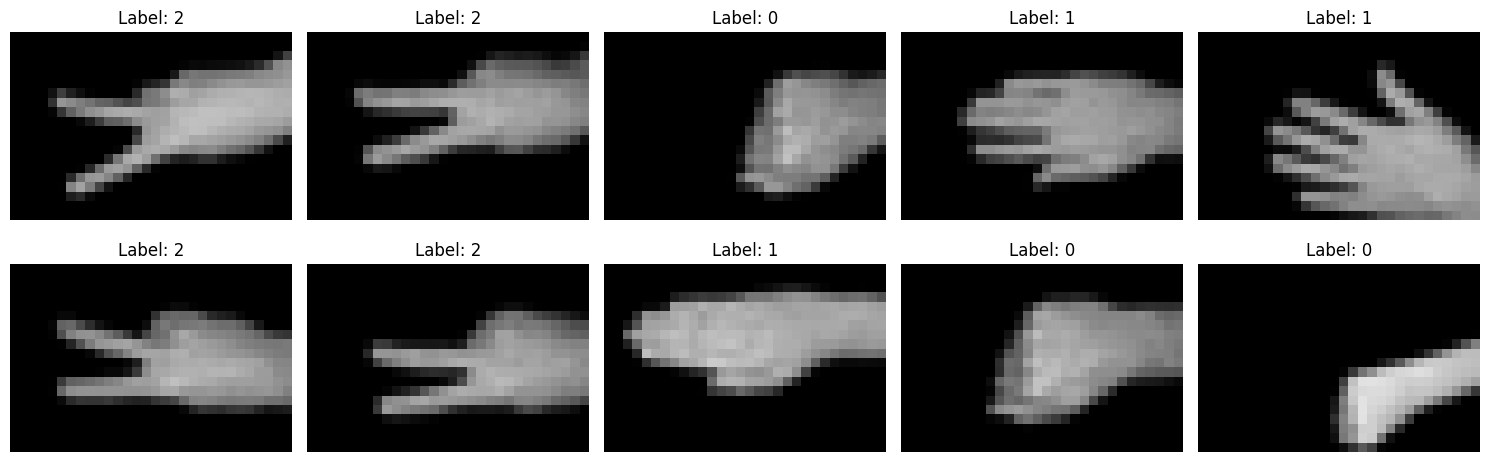

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img

# Ruta al archivo CSV de entrenamiento
train_csv_path = "../data/training_labels.csv"

# Cargar el archivo CSV
train_df = pd.read_csv(train_csv_path)

# Seleccionar las primeras 10 imágenes del conjunto de entrenamiento
sample_images = train_df.head(10)

# Crear una figura para mostrar las imágenes
plt.figure(figsize=(15, 5))

for i, row in enumerate(sample_images.itertuples(), start=1):
    # Cargar la imagen desde la ruta
    img = load_img(row.path)
    
    # Mostrar la imagen
    plt.subplot(2, 5, i)  # Crear una cuadrícula de 2 filas y 5 columnas
    plt.imshow(img, cmap="gray")  # Mostrar en escala de grises si es necesario
    plt.title(f"Label: {row.label}")
    plt.axis("off")  # Ocultar los ejes

# Mostrar todas las imágenes
plt.tight_layout()
plt.show()

Creación del Modelo

In [36]:
#Creacion de modelo de redes neuronales convolucionales
import tensorflow as tf


model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32 , (3,3), input_shape=(20, 30, 1), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),

    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(50, activation='relu'),
    # tf.keras.layers.Dropout(0.3),
    # tf.keras.layers.Dense(50, activation='relu'),

    tf.keras.layers.Dense(3, activation='softmax')  
])


# Compilación del modelo
model.compile(
    optimizer='adam',
    loss= tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

c:\Users\sebas\Desktop\Universidad\Semestre 2025-25\IA\Proyecto 1\Piedra-Papel-Tijera-IA\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Entrenamiento del modelo

In [37]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Crear un generador de datos con aumentos
datagen = ImageDataGenerator(
    rotation_range=30,         # Rotar las imágenes hasta 30 grados
    width_shift_range=0.2,     # Desplazar horizontalmente hasta un 20%
    height_shift_range=0.2,    # Desplazar verticalmente hasta un 20%
    shear_range=0.2,           # Aplicar transformaciones de corte
    zoom_range=0.2,            # Hacer zoom dentro de un rango del 20%
    horizontal_flip=True,      # Voltear horizontalmente las imágenes
    fill_mode='nearest',       # Cómo rellenar los píxeles vacíos tras las transformaciones
    rescale=1.0/255.0          # Normalizar los valores de los píxeles entre 0 y 1
)

# Ruta al archivo CSV de entrenamiento
train_csv_path = "../data/training_labels.csv"

# Cargar el archivo CSV
train_df = pd.read_csv(train_csv_path)

# Convertir las etiquetas a cadenas
train_df['label'] = train_df['label'].astype(str)

# Dimensiones de las imágenes
IMG_HEIGHT = 20
IMG_WIDTH = 30

# Crear un generador a partir del DataFrame
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory="../data/",  # Las rutas en el CSV ya son completas
    x_col="path",    # Columna con las rutas de las imágenes
    y_col="label",   # Columna con las etiquetas
    target_size=(IMG_HEIGHT, IMG_WIDTH),  # Redimensionar las imágenes
    color_mode="grayscale",               # Convertir las imágenes a escala de grises
    class_mode="sparse",                  # Etiquetas en formato entero
    batch_size=32,                        # Tamaño del lote
    shuffle=True                          # Barajar las imágenes
)

# Entrenar el modelo usando el generador
EPOCHS = 20

print("Entrenando el modelo con aumento de datos...")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=EPOCHS
)

print("Modelo entrenado con éxito.")

Found 1531 validated image filenames belonging to 3 classes.
Entrenando el modelo con aumento de datos...
Epoch 1/20


c:\Users\sebas\Desktop\Universidad\Semestre 2025-25\IA\Proyecto 1\Piedra-Papel-Tijera-IA\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


47/47 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - accuracy: 0.3884 - loss: 1.4036
Epoch 2/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.5312 - loss: 1.0842
Epoch 3/20
 1/47 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - accuracy: 0.6562 - loss: 1.0328

c:\Users\sebas\Desktop\Universidad\Semestre 2025-25\IA\Proyecto 1\Piedra-Papel-Tijera-IA\venv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - accuracy: 0.6916 - loss: 0.9082
Epoch 4/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 652us/step - accuracy: 0.8750 - loss: 0.6238
Epoch 5/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.7897 - loss: 0.6735
Epoch 6/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 707us/step - accuracy: 0.8438 - loss: 0.5356
Epoch 7/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - accuracy: 0.8294 - loss: 0.5916
Epoch 8/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 543us/step - accuracy: 0.7188 - loss: 0.7046
Epoch 9/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 87ms/step - accuracy: 0.8214 - loss: 0.5838
Epoch 10/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - accuracy: 0.8750 - loss: 0.4802
Epoch 11/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 78ms/step - accuracy: 0.8385 - loss: 0.5251
Epoch 12/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - accuracy: 0.8438 - loss: 0.5661
Epoch 13/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 4s 86ms/step - accuracy: 0.8594 - loss: 0.5005
Epoch 14/20
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 539us/step - accuracy: 0.

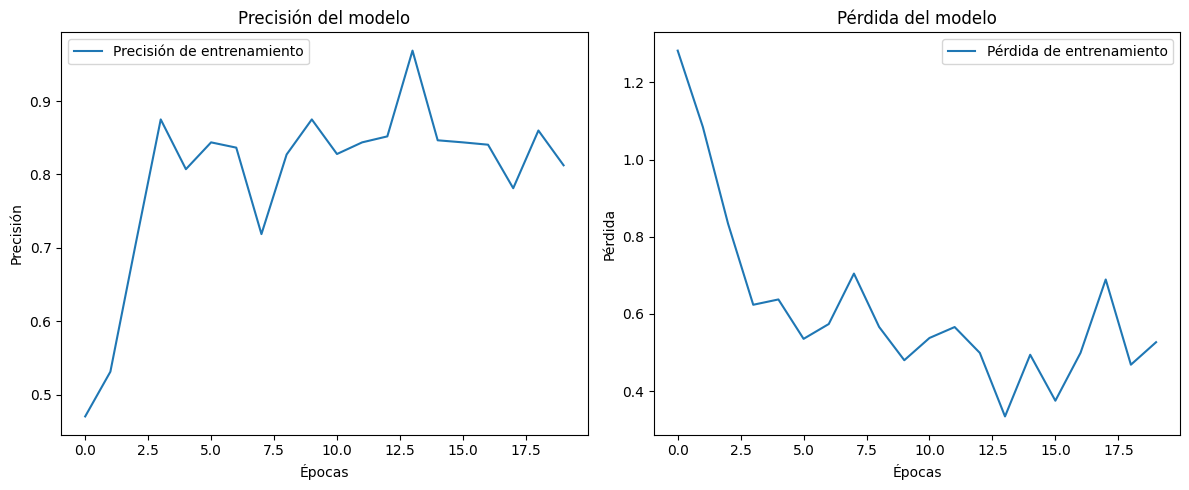

In [38]:
import matplotlib.pyplot as plt

# Graficar la precisión del modelo
plt.figure(figsize=(12, 5))

# Precisión
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Precisión de entrenamiento')
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'], label='Precisión de validación')
plt.title('Precisión del modelo')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.legend()

# Pérdida
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Pérdida de entrenamiento')
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Pérdida de validación')
plt.title('Pérdida del modelo')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()

# Mostrar las gráficas
plt.tight_layout()
plt.show()

Prueba de testeo

In [39]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Ruta al archivo CSV de test
test_csv_path = "../data/test_labels.csv"

# Cargar el archivo CSV
test_df = pd.read_csv(test_csv_path)

# Dimensiones de las imágenes
IMG_HEIGHT = 20
IMG_WIDTH = 30

# Cargar imágenes y etiquetas desde el CSV
X_test = np.array([
    img_to_array(load_img(row.path, target_size=(IMG_HEIGHT, IMG_WIDTH), color_mode="grayscale"))
    for row in test_df.itertuples()
])
y_test = test_df['label'].values  # Etiquetas

# Evaluar el modelo
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Pérdida en el conjunto de test: {test_loss:.4f}")
print(f"Precisión en el conjunto de test: {test_accuracy:.4f}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.9269 - loss: 35.6956
Pérdida en el conjunto de test: 36.1701
Precisión en el conjunto de test: 0.9239
